In [2]:
DATASETS_CV = {1, 2}
DATASETS_ADDITIONAL = {3, 9, 10, 11}

sample_rate = 44100
subsampling_step = 1
min_pitch = 40
max_pitch = 88
onset_group_threshold_seconds = 0.05

image_data_format = 'channels_first'
cqt_configs = [
    {
        'hop_length': 512,
        'fmin': 55.0,
        'n_bins': 180,
        'bins_per_octave': 36,
        'scale': False,
    },
]
n_frames_before = 15
n_frames_after = 20

LOSS = 'binary_crossentropy'
OPTIMIZER = 'adam'
METRICS = None
BATCH_SIZE = 256

In [3]:
wav_file_paths_cv, truth_dataset_format_tuples_cv = get_wav_and_truth_files(DATASETS_CV)
wav_file_paths_additional, truth_dataset_format_tuples_additional = get_wav_and_truth_files(DATASETS_ADDITIONAL)

C:\Users\Michel\FH\IP6\git\music_transcription\onset_detection\read_data.py:133: UserWarning: Skipping AR_Lick11_FN.wav, no truth found.
  warn('Skipping ' + wav_file + ', no truth found.')
C:\Users\Michel\FH\IP6\git\music_transcription\onset_detection\read_data.py:133: UserWarning: Skipping AR_Lick11_KN.wav, no truth found.
  warn('Skipping ' + wav_file + ', no truth found.')
C:\Users\Michel\FH\IP6\git\music_transcription\onset_detection\read_data.py:133: UserWarning: Skipping AR_Lick11_MN.wav, no truth found.
  warn('Skipping ' + wav_file + ', no truth found.')
C:\Users\Michel\FH\IP6\git\music_transcription\onset_detection\read_data.py:135: UserWarning: Skipping ..\data\IDMT-SMT-GUITAR_V2\dataset2\audio\desktop.ini, not a .wav file.
  warn('Skipping ' + path_to_wav + ', not a .wav file.')
C:\Users\Michel\FH\IP6\git\music_transcription\onset_detection\read_data.py:133: UserWarning: Skipping FS_Lick11_FN.wav, no truth found.
  warn('Skipping ' + wav_file + ', no truth found.')
C:\Users

In [4]:
folds = []
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
for k, (train_indices, test_indices) in enumerate(k_fold.split(wav_file_paths_cv)):
    if k > 0:
        print('Skipping split {}'.format(k))
        continue
    
    wav_file_paths_train = [wav_file_paths_cv[i] for i in train_indices] + wav_file_paths_additional
    truth_dataset_format_tuples_train = [truth_dataset_format_tuples_cv[i] for i in train_indices] + truth_dataset_format_tuples_additional
    wav_file_paths_test = [wav_file_paths_cv[i] for i in test_indices]
    truth_dataset_format_tuples_test = [truth_dataset_format_tuples_cv[i] for i in test_indices]
    
    data_train, y_train, wav_file_paths_train_valid, truth_dataset_format_tuples_train_valid = read_data_y(
        wav_file_paths_train, truth_dataset_format_tuples_train,
        sample_rate, subsampling_step,
        min_pitch, max_pitch,
        onset_group_threshold_seconds=onset_group_threshold_seconds
    )
    
    feature_extractor = CnnCqtFeatureExtractor(image_data_format, sample_rate, cqt_configs, n_frames_before, n_frames_after)
    list_of_X_train, sample_file_indexes_train = feature_extractor.fit_transform(data_train)

    data_test, y_test, wav_file_paths_test_valid, truth_dataset_format_tuples_test_valid = read_data_y(
        wav_file_paths_test, truth_dataset_format_tuples_test,
        sample_rate, subsampling_step,
        min_pitch, max_pitch,
        onset_group_threshold_seconds=onset_group_threshold_seconds
    )
    list_of_X_test, sample_file_indexes_test = feature_extractor.transform(data_test, verbose=True)

    folds.append((list_of_X_train, y_train, list_of_X_test, y_test))

C:\Users\Michel\FH\IP6\git\music_transcription\pitch_detection\read_data.py:90: UserWarning: Skipping ..\data\IDMT-SMT-GUITAR_V2\dataset2\annotation\AR_NH_IV.xml, pitch 92 is out of range.
  warn('Skipping {}, pitch {} is out of range.'.format(path_to_xml, pitch))
C:\Users\Michel\FH\IP6\git\music_transcription\pitch_detection\read_data.py:90: UserWarning: Skipping ..\data\IDMT-SMT-GUITAR_V2\dataset2\annotation\AR_NH_IX.xml, pitch 92 is out of range.
  warn('Skipping {}, pitch {} is out of range.'.format(path_to_xml, pitch))
C:\Users\Michel\FH\IP6\git\music_transcription\pitch_detection\read_data.py:90: UserWarning: Skipping ..\data\IDMT-SMT-GUITAR_V2\dataset2\annotation\FS_NH_IV.xml, pitch 92 is out of range.
  warn('Skipping {}, pitch {} is out of range.'.format(path_to_xml, pitch))
C:\Users\Michel\FH\IP6\git\music_transcription\pitch_detection\read_data.py:90: UserWarning: Skipping ..\data\IDMT-SMT-GUITAR_V2\dataset2\annotation\FS_NH_IX.xml, pitch 92 is out of range.
  warn('Skipping

Creating spectrograms
Fitting standard scalers for each spectrogram and bin
(515965, 180)
3.63677319949
22.0932928692
Standardizing for each spectrogram and bin
-2.02342757837e-16
1.0
(4466, 36, 180)
Reshaping data
(4466, 1, 36, 180)


C:\Users\Michel\FH\IP6\git\music_transcription\pitch_detection\read_data.py:90: UserWarning: Skipping ..\data\IDMT-SMT-GUITAR_V2\dataset2\annotation\LP_NH_IX.xml, pitch 92 is out of range.
  warn('Skipping {}, pitch {} is out of range.'.format(path_to_xml, pitch))


Creating spectrograms
(73188, 180)
5.06737530463
27.5702815749
Standardizing for each spectrogram and bin
0.0824521316465
1.19121556558
(633, 36, 180)
Reshaping data
(633, 1, 36, 180)
Skipping split 1
Skipping split 2
Skipping split 3
Skipping split 4


In [8]:
def predict(model, proba_threshold, list_of_X, y, epsilon=1e-7):
    proba_matrix = model.predict(list_of_X)
    y = proba_matrix > proba_threshold
    y = y.astype(np.int8)

    # Make sure at least one pitch is returned.
    for probas, labels in zip(proba_matrix, y):
        if labels.sum() == 0:
            max_proba = max(probas)
            max_index = np.where(np.logical_and(probas > max_proba - epsilon, probas < max_proba + epsilon))[0][0]
            labels[max_index] = 1

    return y

def print_metrics(y, y_predicted):
    accuracy = round(accuracy_score(y, y_predicted), 4)
    print('Accuracy: {}'.format(accuracy))
    print(classification_report(y, y_predicted, digits=3,
                                target_names=[str(pitch) for pitch in range(min_pitch, max_pitch + 1)]))
    
    return accuracy

In [6]:
def create_model_11(list_of_X, n_output_units,
                    dropout_conv=None, dropout_dense=None,
                    n_filters=None, filter_size=None, pool_size=None):
    inputs = []
    conv_blocks = []
    for X in list_of_X:
        spectrogram = Input(shape=X.shape[1:])
        inputs.append(spectrogram)

        conv = Conv2D(10, (10, 3), padding='valid')(spectrogram)
        conv = Activation('relu')(conv)
        conv = MaxPooling2D(pool_size=(6, 3))(conv)
        conv = Dropout(0.15)(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)

        conv = Conv2D(512, (10, 180), strides=(5, 1), padding='valid')(spectrogram)
        conv = Activation('relu')(conv)
        conv = MaxPooling2D(pool_size=(2, 1))(conv)
        conv = Dropout(0.25)(conv)
        conv = Flatten()(conv)
        conv_blocks.append(conv)

    z = Concatenate()(conv_blocks)
    z = Dense(256)(z)
    z = Activation('relu')(z)
    z = Dropout(0.3)(z)
    output = Dense(n_output_units, activation='sigmoid')(z)

    model = Model(inputs, output)
    model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    model.summary()

    return model

In [9]:
list_of_X_train, y_train, list_of_X_test, y_test = folds[0]
n = 10
sample_counts = []
scores = []
for i in range(1, n + 1):
    list_of_X_train_i = []
    for X in list_of_X_train:
        limit = int(X.shape[0] * i / n)
        X_cut = X[:limit, :, :, :]
        list_of_X_train_i.append(X_cut)
    y_train_i = y_train[:limit, :]
    
    model = create_model_11(list_of_X_train_i, max_pitch - min_pitch + 1)
    model.fit(list_of_X_train_i, y_train_i,
              epochs=1000,
              batch_size=BATCH_SIZE,
              sample_weight=None,
              class_weight=None,
              callbacks=[EarlyStopping(monitor='loss', patience=6)],
              verbose=0)

    y_test_predicted = predict(model, 0.5, list_of_X_test, y_test)
    accuracy = print_metrics(y_test, y_test_predicted)
    
    sample_counts.append(limit)
    scores.append(accuracy)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 36, 180)    0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 10, 27, 178)   310                                          
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 512, 6, 1)     922112                                       
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 10, 27, 178)   0                                            
___________________________________________________________________________________________

D:\ProgramFiles\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ProgramFiles\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 1, 36, 180)    0                                            
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 10, 27, 178)   310                                          
____________________________________________________________________________________________________
conv2d_4 (Conv2D)                (None, 512, 6, 1)     922112                                       
____________________________________________________________________________________________________
activation_4 (Activation)        (None, 10, 27, 178)   0                                            
___________________________________________________________________________________________

D:\ProgramFiles\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\ProgramFiles\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 1, 36, 180)    0                                            
____________________________________________________________________________________________________
conv2d_7 (Conv2D)                (None, 10, 27, 178)   310                                          
____________________________________________________________________________________________________
conv2d_8 (Conv2D)                (None, 512, 6, 1)     922112                                       
____________________________________________________________________________________________________
activation_10 (Activation)       (None, 10, 27, 178)   0                                            
___________________________________________________________________________________________

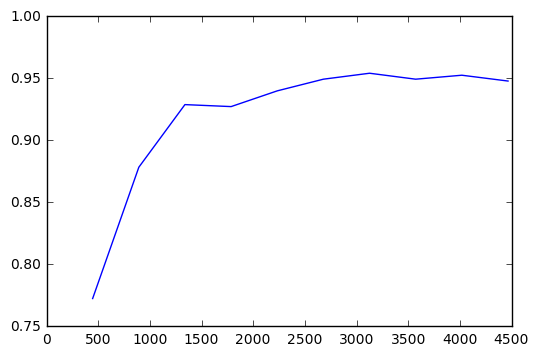

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline

_ = plt.plot(sample_counts, scores)